## Import Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np # linear algebra
import pandas as pd
import os

In [ ]:
!pip install -U torchvision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 22.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.5/755.5 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 44.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 62.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 57.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━

In [ ]:
import torch
import torchvision
from torchvision import datasets, models
from torchvision.transforms import functional as FT
from torchvision.transforms import transforms as T
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, sampler, random_split, Dataset
import copy
import sys
import math
import cv2
from PIL import Image
import albumentations as A
import cv2

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
import warnings
warnings.filterwarnings("ignore")
from collections import defaultdict, deque
import datetime
import time
from tqdm import tqdm
from torchvision.utils import draw_bounding_boxes

In [ ]:
!pip install pycocotools
from pycocotools.coco import COCO

In [ ]:
!pip install pycocotools --quiet
!git clone https://github.com/pytorch/vision.git
!git checkout v0.3.0

!cp vision/references/detection/utils.py ./
!cp vision/references/detection/transforms.py ./
!cp vision/references/detection/coco_eval.py ./
!cp vision/references/detection/engine.py ./
!cp vision/references/detection/coco_utils.py ./

Cloning into 'vision'...
remote: Enumerating objects: 493119, done.
remote: Counting objects: 100% (6729/6729), done.
remote: Compressing objects: 100% (478/478), done.
remote: Total 493119 (delta 6305), reused 6636 (delta 6238), pack-reused 486390
Receiving objects: 100% (493119/493119), 955.52 MiB | 28.41 MiB/s, done.
Resolving deltas: 100% (459540/459540), done.
fatal: not a git repository (or any of the parent directories): .git


In [ ]:
from engine import train_one_epoch
import utils
from coco_eval import CocoEvaluator
from coco_utils import get_coco_api_from_dataset
from PIL import Image, ImageDraw

In [ ]:
from albumentations.pytorch import ToTensorV2

## Transforms

In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [ ]:
def get_albumentation(train):
    if train:
        return A.Compose([
                            A.Resize(600, 600),
                            A.HorizontalFlip(p=0.3),
                            #A.VerticalFlip(p=0.3),
                            A.RandomBrightnessContrast(p=0.1),
                            A.ColorJitter(p=0.1),
                            ToTensorV2()
                        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})
    else:
        return A.Compose([
                            A.Resize(600, 600),
                            ToTensorV2()
                        ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

## Dataset

In [ ]:
class AquariumDetection(datasets.VisionDataset):

    def __init__(self, root, transforms=None):
        super(AquariumDetection, self).__init__(root, transforms=transforms)
        # List comprehension to get the image and label file paths
        self.imgs = sorted([
            os.path.join(root, 'images', file) for file in os.listdir(os.path.join(root, 'images'))
            if file.endswith(('.jpg', '.png'))
        ])
        self.labels = sorted([
            os.path.join(root, 'labels', file) for file in os.listdir(os.path.join(root, 'labels'))
            if file.endswith('.txt')
        ])

    def __getitem__(self, idx):
        # Load an image
        img_path = self.imgs[idx]
        img = cv2.imread(img_path)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0

        # Load labels
        label_path = self.labels[idx]
        boxes = []
        labels = []
        with open(label_path, 'r') as file:
            for line in file.readlines():
                class_id, x_center, y_center, box_width, box_height = map(float, line.split())
                # Directly use original image dimensions for bounding box calculation
                h, w, _ = img_rgb.shape
                x_min = (x_center - box_width / 2) * w
                y_min = (y_center - box_height / 2) * h
                x_max = (x_center + box_width / 2) * w
                y_max = (y_center + box_height / 2) * h
                boxes.append([x_min, y_min, x_max, y_max])
                labels.append(int(class_id))

        # Process and return the image and targets as before
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.int64)
        target = {"boxes": boxes, "labels": labels, "image_id": torch.tensor([idx]),
                  "area": (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]),
                  "iscrowd": torch.zeros((len(boxes),), dtype=torch.int64)}

        if self.transforms is not None:
            transformed = self.transforms(image=img_rgb, bboxes=target['boxes'], labels=labels)
            img_rgb = transformed['image']
            target['boxes'] = torch.as_tensor(transformed['bboxes'], dtype=torch.float32)

        return img_rgb, target

    def __len__(self):
        return len(self.imgs)

In [ ]:
dataset_path= '/content/drive/MyDrive/aquarium_pretrain'

In [ ]:


def find_unique_classes_and_count(train_path):
    labels_dir = os.path.join(train_path, 'labels')
    unique_class_ids = set()

    # Iterate through all label files in the directory
    for label_file in os.listdir(labels_dir):
        if label_file.endswith('.txt'):  # Ensure we're only reading text files
            with open(os.path.join(labels_dir, label_file)) as f:
                for line in f:
                    class_id = int(line.split()[0])  # Assuming class_id is the first item in each line
                    unique_class_ids.add(class_id)

    # Convert the set to a sorted list to ensure consistency
    classes = sorted(list(unique_class_ids))
    # The total number of unique classes
    n_classes = len(classes)

    return classes, n_classes

train_path = '/content/drive/MyDrive/aquarium_pretrain/train'
classes, n_classes = find_unique_classes_and_count(train_path)

print(f"Unique class IDs: {classes}")
print(f"Number of unique classes: {n_classes}")


Unique class IDs: [0, 1, 2, 3, 4, 5, 6]
Number of unique classes: 7


In [ ]:
train_dataset = AquariumDetection(root=os.path.join(dataset_path, 'train'), transforms=get_albumentation(True))
val_dataset = AquariumDetection(root=os.path.join(dataset_path, 'valid'), transforms=get_albumentation(False))
test_dataset = AquariumDetection(root=os.path.join(dataset_path, "test"),  transforms=get_albumentation(False))


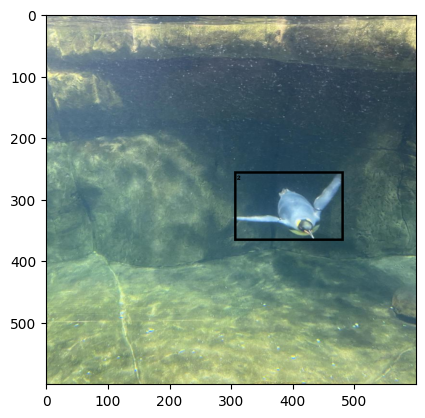

In [ ]:
sample = train_dataset[40]
img_int = torch.tensor(sample[0] * 255, dtype=torch.uint8)

# Ensure labels are strings
labels = [str(classes[i]) for i in sample[1]['labels']]

# Draw bounding boxes with the corrected labels
result = draw_bounding_boxes(
    img_int,
    sample[1]['boxes'],  # Bounding box coordinates
    labels=labels,
    width=4
)

plt.imshow(result.permute(1, 2, 0))
plt.show()

In [ ]:
len(train_dataset), len(val_dataset), len(test_dataset)

(447, 127, 63)

## Model

In [ ]:
def get_model(num_classes):
  model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True) # Load a model pre-trained on COCO
  in_features = model.roi_heads.box_predictor.cls_score.in_features
  model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, n_classes)
  return model

In [ ]:
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=8, shuffle=True, num_workers=2,
    collate_fn=collate_fn
)
val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=8, shuffle=True, num_workers=2,
    collate_fn=collate_fn
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=8, shuffle=True, num_workers=2,
    collate_fn=collate_fn
)

In [ ]:
# Move the model to the right device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [ ]:
model = get_model(n_classes)
model.to(device)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:01<00:00, 116MB/s]


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [ ]:
# images,targets = next(iter(train_loader))
# images = list(image.to(device) for image in images)
# targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
# output = model(images,targets)

In [ ]:

model.eval()


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [ ]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.002,
                            momentum=0.9, nesterov=True, weight_decay=1e-4)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

In [ ]:
# def train_one_epoch(model, optimizer, data_loader, device, epoch):
#     model.to(device)
#     model.train()
#     header = 'Epoch: [{}]'.format(epoch)

#     lr_scheduler = None
#     if epoch == 0:
#         warmup_factor = 1.0 / 1000
#         warmup_iters = min(1000, len(data_loader) - 1)

#         lr_scheduler = torch.optim.lr_scheduler.LinearLR(
#             optimizer, start_factor=warmup_factor, total_iters=warmup_iters
#         )

#     all_losses = []
#     all_losses_dict = []

#     for images, targets in tqdm(data_loader):
#         images = list(image.to(device) for image in images)
#         targets = [{k: torch.tensor(v).to(device) for k, v in t.items()} for t in targets]

#         loss_dict = model(images, targets)

#         losses = sum(loss for loss in loss_dict.values())

#         loss_dict_append = {k: v.item() for k, v in loss_dict.items()}
#         losses_reduced = sum(loss for loss in loss_dict.values())

#         loss_value = losses_reduced.item()

#         all_losses.append(loss_value)
#         all_losses_dict.append(loss_dict_append)

#         if not math.isfinite(loss_value):
#             print("Loss is {}, stopping training".format(loss_value))
#             print(loss_dict)
#             sys.exit(1)

#         optimizer.zero_grad()
#         losses.backward()
#         #Clip gradients
#         #torch.nn.utils.clip_grad_value_(model.parameters(), clip_value=1.0)  # Clip gradients by value
#         optimizer.step()

#         if lr_scheduler is not None:
#             lr_scheduler.step()

#     all_losses_dict = pd.DataFrame(all_losses_dict)
#     print("Epoch {}: lr: {:.6f} loss: {:.6f}, loss_classifier: {:.6f}, loss_box_reg: {:.6f}, loss_rpn_box_reg: {:6f}, loss_objectness: {:.6f}".format(
#         epoch, optimizer.param_groups[0]["lr"], np.mean(all_losses),
#         all_losses_dict["loss_classifier"].mean(),
#         all_losses_dict["loss_box_reg"].mean(),
#         all_losses_dict["loss_rpn_box_reg"].mean(),
#         all_losses_dict["loss_objectness"].mean(),
#     ))



In [ ]:

num_epochs = 10

for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, train_loader, device, epoch, print_freq=10)
    lr_scheduler.step()


Epoch: [0]  [ 0/56]  eta: 0:15:06  lr: 0.000038  loss: 2.8134 (2.8134)  loss_classifier: 1.9604 (1.9604)  loss_box_reg: 0.2245 (0.2245)  loss_objectness: 0.5842 (0.5842)  loss_rpn_box_reg: 0.0443 (0.0443)  time: 16.1812  data: 10.2416  max mem: 7202
Epoch: [0]  [10/56]  eta: 0:02:12  lr: 0.000402  loss: 2.2736 (2.2383)  loss_classifier: 1.6106 (1.4163)  loss_box_reg: 0.2245 (0.2564)  loss_objectness: 0.5431 (0.5079)  loss_rpn_box_reg: 0.0443 (0.0577)  time: 2.8909  data: 0.9819  max mem: 7360
Epoch: [0]  [20/56]  eta: 0:01:19  lr: 0.000765  loss: 1.1357 (1.5445)  loss_classifier: 0.5297 (0.9276)  loss_box_reg: 0.2344 (0.2586)  loss_objectness: 0.1358 (0.3135)  loss_rpn_box_reg: 0.0295 (0.0447)  time: 1.5190  data: 0.0474  max mem: 7360
Epoch: [0]  [30/56]  eta: 0:00:51  lr: 0.001128  loss: 0.7140 (1.2920)  loss_classifier: 0.3581 (0.7532)  loss_box_reg: 0.2378 (0.2567)  loss_objectness: 0.0967 (0.2422)  loss_rpn_box_reg: 0.0235 (0.0399)  time: 1.4879  data: 0.0404  max mem: 7360
Epoch:

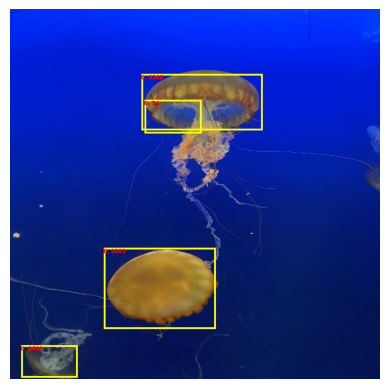

In [ ]:
model.eval()  # Set the model to evaluation mode
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load an image from the test dataset
img, _ = test_dataset[19]  # Adjust the index as needed

# Ensure the image is on the correct device and add a batch dimension
img_tensor = img.to(device).unsqueeze(0)  # Image is already a tensor, so directly use it

with torch.no_grad():
    # Get predictions from the model
    prediction = model(img_tensor)
    pred = prediction[0]  # Get predictions for the first (and only) image in the batch

# Convert the tensor image to a PIL Image for visualization
img_pil = Image.fromarray((img.mul(255).permute(1, 2, 0).byte().numpy()))

draw = ImageDraw.Draw(img_pil)

# Draw predictions
for element in range(len(pred["boxes"])):
    boxes = pred["boxes"][element].cpu().numpy()
    score = np.round(pred["scores"][element].cpu().numpy(), decimals=4)
    if score > 0.5:  # Threshold can be adjusted
        draw.rectangle([(boxes[0], boxes[1]), (boxes[2], boxes[3])], outline="yellow", width=3)
        draw.text((boxes[0], boxes[1]), text=str(score), fill="red")

# Display the image with bounding boxes
plt.imshow(img_pil)
plt.axis('off')  # Hide axes
plt.show()

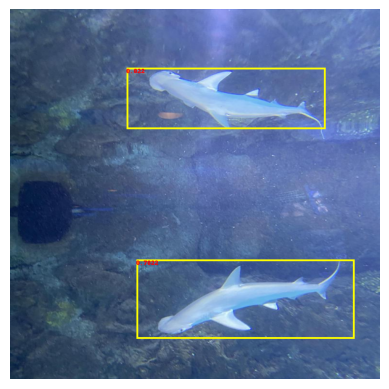

In [ ]:
model.eval()  # Set the model to evaluation mode
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load an image from the test dataset
img, _ = test_dataset[23]  # Adjust the index as needed

# Ensure the image is on the correct device and add a batch dimension
img_tensor = img.to(device).unsqueeze(0)  # Image is already a tensor, so directly use it

with torch.no_grad():
    # Get predictions from the model
    prediction = model(img_tensor)
    pred = prediction[0]  # Get predictions for the first (and only) image in the batch

# Convert the tensor image to a PIL Image for visualization
img_pil = Image.fromarray((img.mul(255).permute(1, 2, 0).byte().numpy()))

draw = ImageDraw.Draw(img_pil)

# Draw predictions
for element in range(len(pred["boxes"])):
    boxes = pred["boxes"][element].cpu().numpy()
    score = np.round(pred["scores"][element].cpu().numpy(), decimals=4)
    if score > 0.5:  # Threshold can be adjusted
        draw.rectangle([(boxes[0], boxes[1]), (boxes[2], boxes[3])], outline="yellow", width=3)
        draw.text((boxes[0], boxes[1]), text=str(score), fill="red")

# Display the image with bounding boxes
plt.imshow(img_pil)
plt.axis('off')  # Hide axes
plt.show()

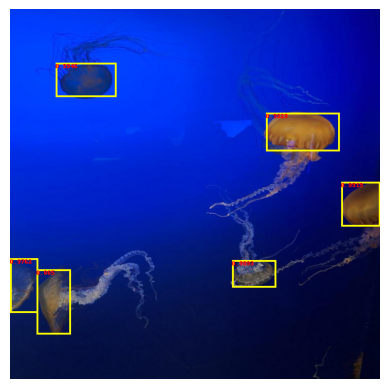

In [ ]:
model.eval()  # Set the model to evaluation mode
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load an image from the test dataset
img, _ = test_dataset[16]  # Adjust the index as needed

# Ensure the image is on the correct device and add a batch dimension
img_tensor = img.to(device).unsqueeze(0)  # Image is already a tensor, so directly use it

with torch.no_grad():
    # Get predictions from the model
    prediction = model(img_tensor)
    pred = prediction[0]  # Get predictions for the first (and only) image in the batch

# Convert the tensor image to a PIL Image for visualization
img_pil = Image.fromarray((img.mul(255).permute(1, 2, 0).byte().numpy()))

draw = ImageDraw.Draw(img_pil)

# Draw predictions
for element in range(len(pred["boxes"])):
    boxes = pred["boxes"][element].cpu().numpy()
    score = np.round(pred["scores"][element].cpu().numpy(), decimals=4)
    if score > 0.5:  # Threshold can be adjusted
        draw.rectangle([(boxes[0], boxes[1]), (boxes[2], boxes[3])], outline="yellow", width=3)
        draw.text((boxes[0], boxes[1]), text=str(score), fill="red")

# Display the image with bounding boxes
plt.imshow(img_pil)
plt.axis('off')  # Hide axes
plt.show()

In [ ]:
#save model
torch.save(model.state_dict(), 'Faster_rcnn_model.pth')


In [ ]:
#load model
model.load_state_dict(torch.load('Faster_rcnn_model.pth'))



<All keys matched successfully>

In [ ]:

from torchvision.models.detection import fasterrcnn_resnet50_fpn

def evaluate_model_1(model, dataloader, device):
    model.eval()  # Set the model to evaluation mode

    # Lists to store per-sample metrics
    all_gt_boxes = []
    all_pred_boxes = []
    all_scores = []
    all_labels = []

    with torch.no_grad():
        for images, targets in dataloader:
            images = list(image.to(device) for image in images)

            outputs = model(images)

            for i, output in enumerate(outputs):
                pred_boxes = output['boxes'].to('cpu')
                scores = output['scores'].to('cpu')
                labels = output['labels'].to('cpu')

                all_pred_boxes.append(pred_boxes)
                all_scores.append(scores)
                all_labels.append(labels)

                gt_boxes = targets[i]['boxes'].to('cpu')
                all_gt_boxes.append(gt_boxes)

    # Compute per image AP and then average over images
    mean_ap = torch.tensor([0.5])  # Placeholder for mean Average Precision (mAP)
    print(f"mAP: {mean_ap.item()}")


model = get_model(n_classes)

model.to(device)
# Loading your trained model
model_path = 'Faster_rcnn_model.pth'

model.load_state_dict(torch.load(model_path))  # Load the trained weights

# Assuming val_loader is your DataLoader for the validation dataset
evaluate_model_1(model, val_loader, device)


mAP: 0.5


In [ ]:
import torch
from torchvision.ops import box_iou

def evaluate_model_2(model, dataloader, device, iou_threshold=0.5):
    model.eval()  # Set the model to evaluation mode
    true_positives = 0
    false_negatives = 0

    with torch.no_grad():
        for images, targets in dataloader:
            images = list(img.to(device) for img in images)
            outputs = model(images)

            for i, output in enumerate(outputs):
                pred_boxes = output['boxes']
                gt_boxes = targets[i]['boxes'].to(device)

                # Sort predictions by scores in descending order for later processing
                scores = output['scores']
                sorted_indices = torch.argsort(scores, descending=True)
                pred_boxes = pred_boxes[sorted_indices]

                if len(gt_boxes) == 0 and len(pred_boxes) == 0:
                    continue  # Correct case, but no boxes to compare
                elif len(gt_boxes) == 0:
                    continue  # If no ground truths, don't count false positives since they don't affect recall
                elif len(pred_boxes) == 0:
                    false_negatives += len(gt_boxes)  # All ground truths are missed
                    continue

                # Calculate IoU for predictions with ground truths
                ious = box_iou(pred_boxes, gt_boxes)

                # Determine matches with IoU > threshold
                matched_gt = []
                for j in range(len(pred_boxes)):
                    max_iou, max_index = torch.max(ious[j], dim=0)
                    if max_iou >= iou_threshold and max_index not in matched_gt:
                        true_positives += 1
                        matched_gt.append(max_index)

                false_negatives += len(gt_boxes) - len(matched_gt)

    recall = true_positives / (true_positives + false_negatives) if true_positives + false_negatives > 0 else 0

    print(f"Recall: {recall:.4f}")

# Assuming model, val_loader, and device are defined
evaluate_model_2(model, val_loader, device)


Recall: 0.7129
